In [4]:
'''A simple simulation to demonstrate active sampling in high dimensions.
As full preposterior inference imposes excessive computational demands, 
a myopic sampling strategy is used (MAX_RECURSION_LEVEL=0).
'''

%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import sys
import glob
sys.path.append('..')
import sea


In [2]:
# %% simulation parameters

param = {
    'MAX_RECURSION_LEVEL':  0,  # 0 is myopic
    'EXPLORATION_PARAM':    0.0,
    'DECISION_PARAMETER':   1.0,
    'TOTAL_BLOCKS':         100,
    'CONSEC_BLOCKS':        2,
    'num_dims':             100,
    'num_values':           2,
    'coupling':             .3,
    'd':                    1.0,
    'report':               False,
    'NUM_TIMES':            5,
    'TRIAL_PER_BLOCK':      10,
}

param['prior_matrix'] = np.array([[1.0, 1.0]] * param['num_dims'])
param['prior_matrix'][0, :] = .01


In [3]:
# functions for computing utility:


def getSituationCost(KNOWN_VEC, param):
    '''function to calculate costs for a given KNOWN_VEC (see RMC.SituationValue)

    This function assumes equal costs for each query. Can be modified for
    tasks in which some tests are more costly than others, or when sampling costs
    are not independent.'''

    return np.sum(KNOWN_VEC) * 0


def dfActionVals(param):
    '''function to define utility table (e.g., table 1)

    When asym is True, this currently maximizes accuracy (i.e., correct=100
    utility units, incorrect=0 utility units).

    This function should be modified to reflect utility and cost associated
    with the final choice.'''

    m = np.diag([100] * param['num_values'])
    df = pd.DataFrame(index=['s%d' % a for a in range(param['num_values'])],
                      columns=['a%d' % a for a in range(param['num_values'])],
                      data=m)
    return df


param['getSituationCost'] = getSituationCost
param['dfActionVals'] = dfActionVals(param)


In [4]:
# %% Standard Model(Active Sampling)

model = sea.RMC(param)

overall_correct = np.zeros([param['TOTAL_BLOCKS']])
overall_sampled = np.zeros([param['TOTAL_BLOCKS']])

KNOWN = np.ones(model.NUM_DIMS).astype(int)
KNOWN[0] = 0    # the category label
QUERY = np.zeros(model.NUM_DIMS)
QUERY[0] = 1

dfC = pd.DataFrame(
    index=range(
        param['NUM_TIMES']), columns=range(
            param['TOTAL_BLOCKS']))
dfS = pd.DataFrame(
    index=range(
        param['NUM_TIMES']), columns=range(
            param['TOTAL_BLOCKS']))

for run_num in range(param['NUM_TIMES']):
    model.Reset()
    if os.path.exists('results/dfS_boot%d_nboot%d_cost%d'%(run_num,param['NUM_TIMES'],0)):
        print('run_num%d exists, skipping'%run_num)
    else:
        tr = 0
        for num_block in tqdm(range(param['TOTAL_BLOCKS']),
                              desc='run%d'%run_num):
            nS = 0
            nC = 0
            for i in range(param['TRIAL_PER_BLOCK']):

                tr += 1

                STIM = np.random.random(model.NUM_DIMS)
                STIM = STIM > .5
                if STIM[1]:  # category label.
                    STIM[0] = 1
                else:
                    STIM[0] = 0

                STIM = STIM.astype(int)

                tempN = model.PresentStimulus(STIM, KNOWN)

                SAMPLED_KNOWN = np.zeros(model.NUM_DIMS)
                SAMPLED_KNOWN[tempN] = 1

                nS += len(tempN)
                overall_sampled[num_block] += len(tempN)
                vC = model.ResponseCorrectProb(STIM, SAMPLED_KNOWN)
                nC += vC
                overall_correct[num_block] += vC
                model.Learn(STIM, SAMPLED_KNOWN, QUERY)


            dfS.loc[run_num, num_block] = nS / param['TRIAL_PER_BLOCK']
            dfC.loc[run_num, num_block] = nC / param['TRIAL_PER_BLOCK']
        dfC.to_csv('results/dfC_boot%d_nboot%d_cost%d'%(run_num,param['NUM_TIMES'],0))
        dfS.to_csv('results/dfS_boot%d_nboot%d_cost%d'%(run_num,param['NUM_TIMES'],0))

overall_correct /= (param['TRIAL_PER_BLOCK'] * param['NUM_TIMES'])
overall_sampled /= (param['TRIAL_PER_BLOCK'] * param['NUM_TIMES'])



run2:   0%|          | 0/100 [00:00<?, ?it/s]

run_num0 exists, skipping
run_num1 exists, skipping


run4: 100%|██████████| 100/100 [2:20:01<00:00, 95.98s/it] 


In [31]:
ps = np.sort(glob.glob('results/dfC*nboot*'))
psS = np.sort(glob.glob('results/dfS*nboot*'))
dftmp = pd.read_csv(ps[0],index_col=0)
dfC = pd.DataFrame(index=dftmp.index,columns=dftmp.columns)
dfS = pd.DataFrame(index=dftmp.index,columns=dftmp.columns)
for i,p in enumerate(ps):
    dftmp = pd.read_csv(p, index_col=0)
    dfC.loc[i,:] =dftmp.loc[i,:]
    dftmp = pd.read_csv(psS[i],index_col=0)
    dfS.loc[i,:] = dftmp.loc[i,:]
print(dfC)
dfC.to_csv('results/lessIsMore_dfC_cost0_5runs.csv')
print(dfS)
dfS.to_csv('results/lessIsMore_dfS_cost0_5runs.csv')

          0         1         2         3         4         5         6  \
0  0.464449  0.659332  0.692889  0.659891  0.580855  0.636382  0.660963   
1  0.497479  0.552929  0.618589  0.466172  0.439833  0.585019  0.662416   
2  0.440527  0.497594  0.620183  0.552888  0.662054  0.640285  0.647025   
3  0.504915  0.505979  0.494813  0.660222  0.663149   0.45278  0.547399   
4  0.389877  0.541984  0.655493  0.554733  0.481705  0.592523  0.629895   

          7         8         9    ...           90        91        92  \
0  0.690002  0.581003   0.52347    ...     0.749662   0.68177  0.696198   
1  0.472186  0.659358  0.573611    ...     0.717602  0.784766  0.740363   
2  0.581808  0.642594  0.414033    ...     0.623555  0.786614  0.667256   
3  0.672489  0.652004  0.322697    ...     0.798919  0.631538  0.821667   
4  0.533084  0.690652  0.497955    ...     0.839389  0.834677  0.838884   

         93        94        95        96        97        98        99  
0  0.781583   0.57163  0

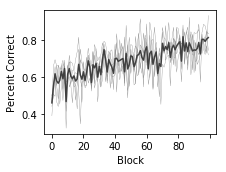

<Figure size 432x288 with 0 Axes>

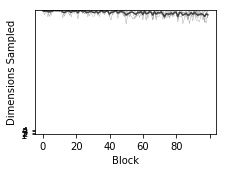

In [30]:
# figures

bk = 1

plt.figure(figsize=(3.25, 2.5))
plt.plot(dfC.T, color=['#b3ccff', '#808080']
         [bk], linewidth=.3)  # ,legend=False)
mn = dfC.mean()
plt.plot(mn, ['#0000ff', '#404040'][bk])
plt.xlabel('Block')
plt.xticks([0,20,40,60,80,100])
plt.ylabel('Percent Correct')
plt.tight_layout()
plt.show();plt.pause(.01)
plt.savefig('results/lessIsMore_cost0_numtimes5.png')

plt.figure(figsize=(3.25, 2.5))
plt.plot(dfS.T, color=['#b3ccff', '#808080']
         [bk], linewidth=.3)  # ,legend=False)
mn = np.mean(dfS, axis=0).values
plt.plot(mn, ['#0000ff', '#404040'][bk])
plt.yticks([1, 2, 3, 4])
plt.xticks([0,20,40,60,80,100])
plt.xlabel('Block')
plt.ylabel('Dimensions Sampled')
plt.tight_layout()
plt.show();plt.pause(.01)


In [6]:
# %% All Dimensions Sampled:

model = sea.RMC(param)

overall_correct = np.zeros([param['TOTAL_BLOCKS']])
overall_sampled = np.zeros([param['TOTAL_BLOCKS']])

KNOWN = np.ones(model.NUM_DIMS).astype(int)
KNOWN[0] = 0  # the category label
QUERY = np.zeros(model.NUM_DIMS)
QUERY[0] = 1

dfC = pd.DataFrame(
    index=range(
        param['NUM_TIMES']), columns=range(
            param['TOTAL_BLOCKS']))
dfS = pd.DataFrame(
    index=range(
        param['NUM_TIMES']), columns=range(
            param['TOTAL_BLOCKS']))

for run_num in range(param['NUM_TIMES']):
    model.Reset()
    tr = 0
    for num_block in tqdm(range(param['TOTAL_BLOCKS']), desc='run %d'%run_num):
        nS = 0
        nC = 0
        for i in range(param['TRIAL_PER_BLOCK']):
            tr += 1
            # make a stimulus...
            STIM = np.random.random(model.NUM_DIMS)
            STIM = STIM > .5
            if STIM[1]:  # first dimension predicts category label.
                STIM[0] = 1
            else:
                STIM[0] = 0
            STIM = STIM.astype(int)

            tempN = np.random.permutation(np.arange(1, 100))
            nS += len(tempN)

            SAMPLED_KNOWN = np.zeros(model.NUM_DIMS)
            SAMPLED_KNOWN[tempN] = 1

            model.Stimulate(STIM, SAMPLED_KNOWN)

            vC = model.ResponseCorrectProb(STIM, SAMPLED_KNOWN)
            nC += vC

            model.Learn(STIM, SAMPLED_KNOWN, QUERY)

        dfS.loc[run_num, num_block] = nS / param['TRIAL_PER_BLOCK']
        dfC.loc[run_num, num_block] = nC / param['TRIAL_PER_BLOCK']


overall_correct /= (param['TRIAL_PER_BLOCK'] * param['NUM_TIMES'])
overall_sampled /= (param['TRIAL_PER_BLOCK'] * param['NUM_TIMES'])



run 4: 100%|██████████| 100/100 [00:01<00:00, 63.12it/s]


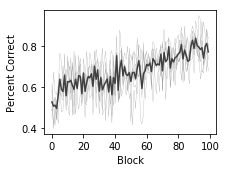

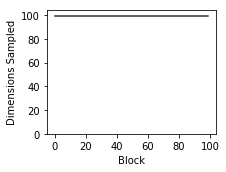

In [7]:
# %% figures:
plt.close('all')
bk = 1

plt.figure(figsize=(3.25, 2.5))
plt.plot(dfC.T, color=['#b3ccff', '#808080']
         [bk], linewidth=.2)  # ,legend=False)
mn = dfC.mean()
plt.plot(mn, ['#0000ff', '#404040'][bk])
plt.xlabel('Block')
plt.xticks(np.arange(0, 101, 20))
plt.ylabel('Percent Correct')
plt.tight_layout()

plt.figure(figsize=(3.25, 2.5))
plt.plot(dfS.T, color=['#b3ccff', '#808080'][bk], linewidth=.2)
plt.xticks(np.arange(0, 101, 20))
mn = np.mean(dfS, axis=0).values
plt.plot(mn, ['#0000ff', '#404040'][bk])
plt.yticks(np.arange(0, 101, 20))
plt.xlabel('Block')
plt.ylabel('Dimensions Sampled')
plt.tight_layout()



In [6]:
os.path.exists('results/dfS_boot%d_nboot%d_cost%d'%(run_num,param['NUM_TIMES'],0))

False

In [8]:
'results/dfS_boot%d_nboot%d_cost%d'%(run_num,param['NUM_TIMES'],0)

'results/dfS_boot0_nboot5_cost0'

In [9]:
ls


behavioral_results/  sim_54.ipynb          sim_less_is_more.ipynb
past_samples/        sim_54.py             sim_rulex.ipynb
results/             sim_Blair_exp2.ipynb  sim_Shepard_Hovland_Jenkins.ipynb
